# Polynomial Regression

In [1]:
# import necessary libraries
import pandas as pd  # for data input/output and processing
import numpy as np  # for matrix calculations

from sklearn.linear_model import LinearRegression  # An already implemented version of linear regression
from sklearn.preprocessing import PolynomialFeatures  # To transform our features to the corresponding polynomial version
from sklearn.metrics import mean_squared_error  # a way to evaluate how erroneous our model is

import matplotlib.pyplot as plt  # For visualizations

In [2]:
plt.rcParams.update({'font.size': 20})

## Data Preprocessing

Preprocessing refers to some data manipulation techniques that are used to make sure that our data carry important information in the format that we expect it to.

Here we are going to use a small dataset of only 60 samples. These correspond to meteorological observations from the Finnish Meteorological Institute (FMI).

In [3]:
# First load the dataset into a pandas DataFrame
df = pd.read_csv("fmi_adjusted.csv")
print("Number of data points:", len(df))
df.head(2)  # print the first 2 rows

Number of data points: 60


,Year,m,d,Time,Time zone,Precipitation amount (mm),Snow depth (cm),Air temperature (degC),Ground minimum temperature (degC),Maximum temperature (degC),Minimum temperature (degC)
0,2020,1,1,00:00,UTC,NaN,NaN,3.0,NaN,4.4,-0.4
1,2020,1,2,00:00,UTC,NaN,NaN,4.4,NaN,5.3,3.2


At first, will consider only the day and the minimum temperature as valid features, while the maximum temperature will be the label.

### Datapoints and Features vs. Labels

- **Datapoint**: A datapoint is a single row of our dataset that represents an object with specific properties.
- **Label**: The value which we want to be able to predict.
- **Features**: All of our dataset's columns that are not the target. It represents the amount of information that we think we need in order to predict the label.

**FMI Example:** 
- We will use the `maximum temperature` as the label 
- We will **consider** the `day` and the `minimum temperature` as possible features.
- Then we get:
  - **Datapoint**: Represents a specific day and its characteristics.
  - **Label**: `Maximum Temperature`
  - **Features**: `Day`, `Minimum Temperature`


In [4]:
feature_columns = ["d", "Minimum temperature (degC)"]
label_column = ["Maximum temperature (degC)"]
# Keep only relevant columns
df = df[feature_columns+label_column]
df.head(2)

,d,Minimum temperature (degC),Maximum temperature (degC)
0,1,-0.4,4.4
1,2,3.2,5.3


In [5]:
df.columns = ['d', 'min_temp', 'max_temp']
df.head(2)

,d,min_temp,max_temp
0,1,-0.4,4.4
1,2,3.2,5.3


In [6]:
# First step: Drop NaN (Not A Number) values
df.dropna(inplace=True)
len(df)

60

Now let's visualize the correlation of the remaining columns with the target variable. For this, we can simply make a scatter plot, as follows:

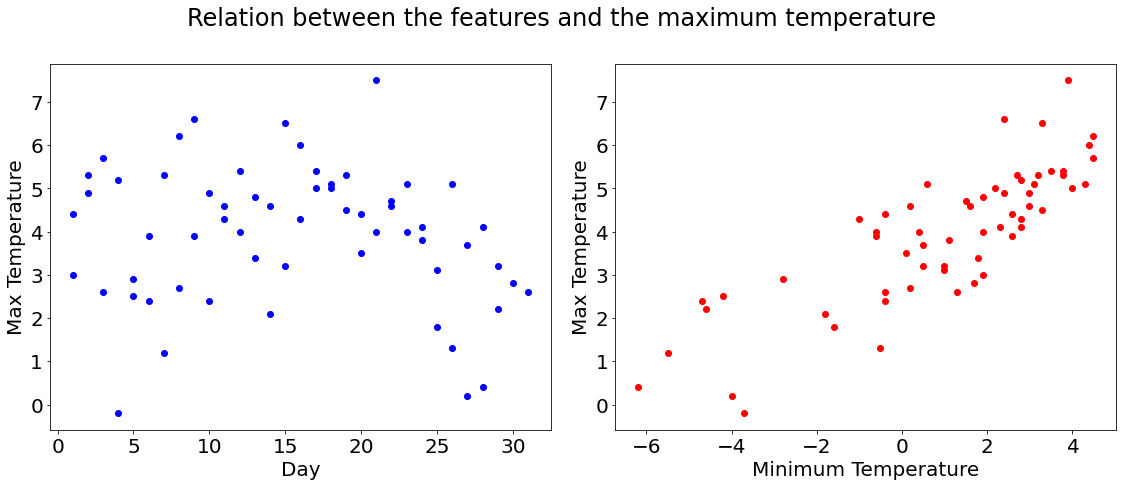

In [7]:
# def plot_model(X, y, 
fig=plt.figure(figsize=(16, 7))
fig.suptitle("Relation between the features and the maximum temperature")
plt.subplot(1, 2, 1)
plt.scatter(df.d, df.max_temp, c="blue")
plt.xlabel("Day")
plt.ylabel("Max Temperature")
plt.subplot(1, 2, 2)
plt.scatter(df.min_temp, df.max_temp, c="red")
plt.xlabel("Minimum Temperature")
plt.ylabel("Max Temperature")
fig.tight_layout()  # Separate the two subplots
plt.show()

The `d` (day) column seems to have a very noisy relationship with the target. On the other hand, the `min_temp` column seems to have a clearly linear relationship with the target and so we consider it important/informative.

For this reason we are going to completely ignore the `d` column and move on with the `min_temp` as our only feature. Using 1 feature also allows for better visualizations in a 2d space (e.g. if we had two features, then we would need 3 axes in total, and 3d plots are not as intuitive as 2d plots. If we had 3 features, then visualization would be impossible).

In [8]:
df.drop(columns=['d'], inplace=True)
df.head(2)

,min_temp,max_temp
0,-0.4,4.4
1,3.2,5.3


In [9]:
# Let's separate features from labels
labels = df.max_temp.values  # .values convert to a numpy array
features = df.drop(columns=['max_temp']).values

## Single Degree Linear Regression

### Loss Function

Linear regression tries to minimize the Mean Squared Error (MSE) loss function, to get the best possible predictor function $h$. MSE is given by: 
$$MSE = \frac{1}{m} \sum_{i=1}^m (y^{(i)} - \hat{h}(x^{(i)}))^2$$

where $\hat{h}(x^{(i)})$ is the regressor's prediction for the $i$-th example. In turn, $x$ is a vector of the features that we want to use in order to get a prediction as close to the ground truth $y^{(i)}$ as possible.

### Predictor Function / Hypothesis
In classicial (single degree) linear regression, the function $\hat{h}$ is a linear combination of the input features:
$$
\hat{h}(x^{(i)}) = w_0 + \sum_{j=1}^{n} w_i x^{(i)}_j = w^T x
$$

where $w_0$, $w_1$, ..., $w_n$ are the parameters of our model (in this case they are also called linear coefficients). Notice that we have $n+1$ parameters (where $n$ is the number of features), since $w_0$ is the bias of the linear function.

In [10]:
# Create a linear regression model
lr = LinearRegression()
# Fit the model to our data in order to get the most suitable parameters
lr = lr.fit(features, labels)

In [11]:
# Calculate the mean square error on the training set
predictions = lr.predict(features)
mean_squared_error(predictions, labels)  # ideally this would be 0 which would mean that the predictions are very close to the ground truth

0.7923096115261259

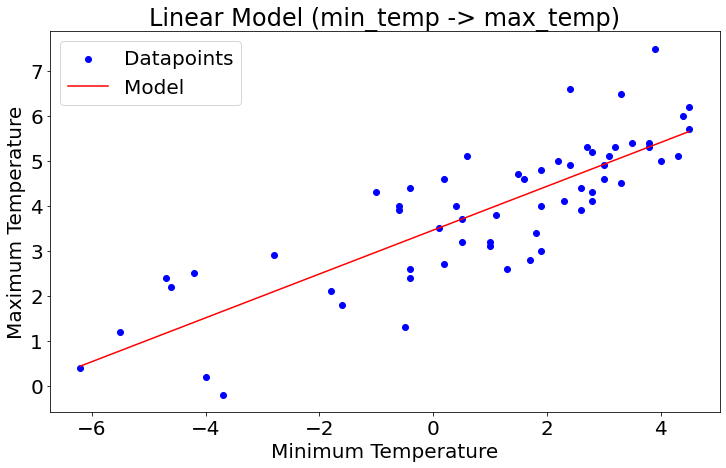

In [12]:
plt.figure(figsize=(12,7))
# How good does the model fit our data?
plt.scatter(features, labels, c="blue", label="Datapoints")
# an increasing vector in the [min, max] range of the features
X_line = np.linspace(features.min(), features.max(), len(features)).reshape(-1, 1)  # needs to be 2d and so we reshape
predictions = lr.predict(X_line)
plt.plot(X_line, predictions, c="red", label="Model")
plt.xlabel("Minimum Temperature")
plt.ylabel("Maximum Temperature")
plt.title("Linear Model (min_temp -> max_temp)")
plt.legend()
plt.show()

## Polynomial Regression

The above predictor function is good for relations $x \rightarrow y$ that exhibit a strictly linear relation. In the figure bellow though, we can see that the relation is not always linear:

![](./non-linear-relation.png)

In such cases, we can increase the degree of the linear function and also include terms raised to some power $r$, for $r>1$.

Getting back to our example, we could now transform the predictor function to:
$$
\hat{h}(x) = w_0 + w_1 x + w_1 x^2 + ... + w_{r+1} x^r
$$

To find the best value of $r$ we usually have to search through a lot of values, as follows:

In [13]:
def get_poly_predictor(features, labels, degree):
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    # transform features so as to include their polynomial version.
    # E.g. feas_new will now also include x^2, ..., x^{degree}
    feas_new = poly_features.fit_transform(features)
    lr = LinearRegression()
    lr.fit(feas_new, labels)
    mse = mean_squared_error(lr.predict(feas_new), labels)
    return mse

In [14]:
# Try out different degrees and print the corresponding MSEs
for r in range(2, 21, 2):
    mse = get_poly_predictor(features, labels, degree=r)
    print(f"Degree={r} -> MSE={mse}")

Degree=2 -> MSE=0.7675768782858959
Degree=4 -> MSE=0.7650214317149964
Degree=6 -> MSE=0.7169865015488852
Degree=8 -> MSE=0.7073782771675975
Degree=10 -> MSE=0.6855393630027092
Degree=12 -> MSE=0.6502596660733234
Degree=14 -> MSE=0.6225170045099109
Degree=16 -> MSE=0.5582969858802566
Degree=18 -> MSE=0.5200486667388982
Degree=20 -> MSE=0.5536063674784653


The errors decrease by a lot as we increase the degree. Does that mean that our model is better?

Let's make a scatter of the models for a degree of 2, 4, 7 and 10:

In [15]:
def poly_visualize(
        features, 
        labels, 
        degrees=[2, 4, 8, 18], 
        colors=['blue', 'green', 'cyan', 'purple'],
        n_wrong_models=0,
    ):
    fig = plt.figure(figsize=(20, 15))
    wrong_poly_colors = ['gold', 'teal', 'tomato', 'firebrick', 'orchid']
    for i, r in enumerate(degrees):
        # ===================================================================
        # Fit model
        # ===================================================================
        poly_features = PolynomialFeatures(degree=r, include_bias=False)
        feas_new = poly_features.fit_transform(features)
        lr = LinearRegression()
        lr.fit(feas_new, labels)
        # ===================================================================
        # Fit some models on wrong data to see how the polynomial changes
        # ===================================================================
        polys_perturbed = []
        for j in range(n_wrong_models):
            feas_perturbed = np.random.permutation(feas_new)
            polys_perturbed.append(LinearRegression().fit(feas_perturbed, labels))
        # ===================================================================
        # Scatter plot
        # ===================================================================
        plt.subplot(2, 2, i+1)
        # How good does the model fit our data?
        plt.scatter(features, labels, c=colors[i], label="Datapoints")
        # an increasing vector in the [min, max] range of the features
        X_line = np.linspace(features.min(), features.max(), 200).reshape(-1, 1)  # needs to be 2d and so we reshape
        predictions = lr.predict(poly_features.transform(X_line))
        plt.plot(X_line, predictions, c="red", label="Best Fitted Model", linewidth=7.0)
        for j in range(n_wrong_models):
            preds_perturbed = polys_perturbed[j].predict(poly_features.transform(X_line))
            color = wrong_poly_colors[j%len(wrong_poly_colors)]
            plt.plot(X_line, preds_perturbed, c=color, label=f"Model {j+2}")
        plt.xlabel("Minimum Temperature")
        plt.ylabel("Maximum Temperature")
        mse = mean_squared_error(lr.predict(feas_new), labels)
        plt.title(f"Degree {r} - MSE={round(mse, 2)}")
        plt.legend()
    plt.show()

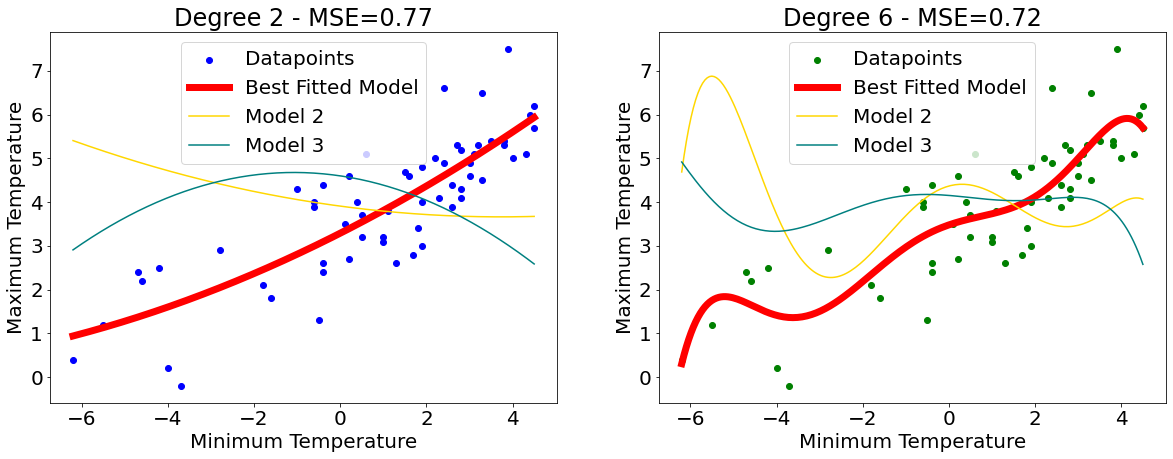

In [16]:
poly_visualize(features, labels, degrees=[2, 6], colors=["blue", "green"], n_wrong_models=2)

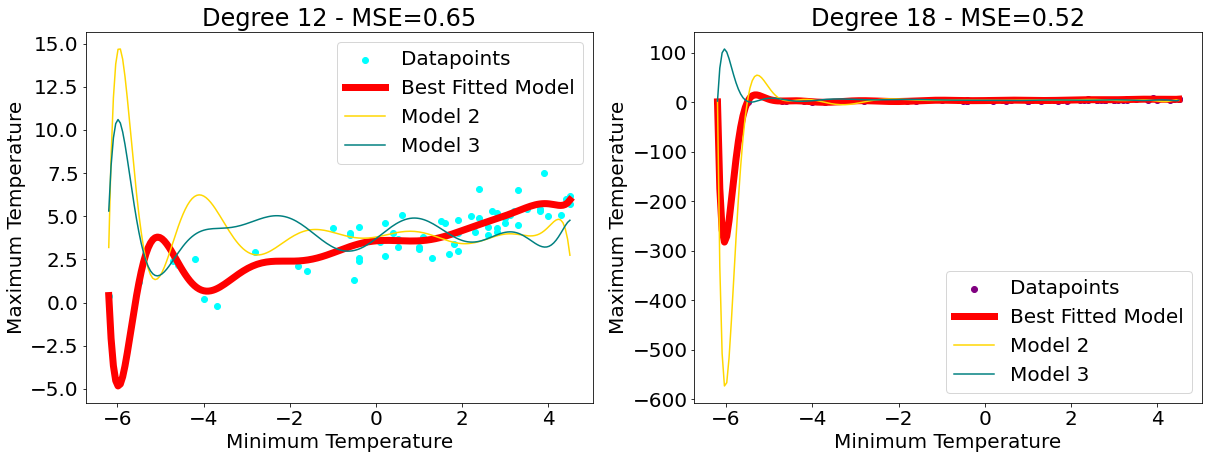

In [17]:
poly_visualize(features, labels, degrees=[12, 18], colors=["cyan", "purple"], n_wrong_models=2)

### Overfitting

As we can see, with a higher polynomial degree of features, we get get a model that fits our data very closely (trying to pass through each and every training example).

This is called **overfitting** and it means that our model will not be able to generalize well on unseen data. For example, with a degree of 18 and an imaginary, new feature $x=-5.5$, our model would return a prediction close to $max\_temp=250$ which *does not satisfy our intuition* that $target$ should be closer to $1$ degree as its neighbours are.